We are not spoilt for choices to work with polynomials of noncommutative variables. [Yalmip](http://users.isy.liu.se/johanl/yalmip/) has undocumented noncommutative functionality for MATLAB. While the rest of the toolbox is regularly updated, the noncommutative parts are neglected. [NCAlgebra](http://www.math.ucsd.edu/~ncalg/) is a package for Mathematica, but its semidefinite programming functions do not seem to be working, and those are the ones we need. [SymPy](http://sympy.org/), a Python library for symbolic mathematics, has basic functionality for noncommutative variables, so I took a closer look whether it is able to generate monomials of arbitrary order. Given that this is an open source solution, I would love to see it working. The discussion below uses SymPy 0.7.5.

To start with, we have to import the library:

In [1]:
from sympy import *
init_printing() 

Defining an arbitrary number of noncommutative variables is easy:

In [2]:
a=symbols('a0:2', commutative=False)

Behold the result:

In [3]:
simplify(a[0]*a[1] + a[1]*a[0])

Trying to generate the monomials of order two, the situation is less rosy:

In [4]:
itermonomials([a[0], a[1]], 2)

The polynomial functions do not support noncommutative variables. An additional problem is that the noncommutative variables are not complex:

In [5]:
a[0].assumptions0

{'algebraic': False,
 'commutative': False,
 'complex': False,
 'composite': False,
 'even': False,
 'imaginary': False,
 'integer': False,
 'irrational': False,
 'negative': False,
 'noninteger': False,
 'nonnegative': False,
 'nonpositive': False,
 'nonzero': True,
 'odd': False,
 'positive': False,
 'prime': False,
 'rational': False,
 'real': False,
 'transcendental': False,
 'zero': False}

The library will drop an error message if you want to define symbols that are both noncommutative and complex. We are not going to get Hermitian conjugates with these variables. A project from Google Summer of Code 2010 took care of such matters:

In [6]:
from sympy.physics.quantum.operator import HermitianOperator, Operator
from sympy.physics.quantum.dagger import Dagger
A = Operator('A')
B = Operator('B')
Dagger(A)

In [7]:
simplify(A*B + B*A)

A new problem is that obtaining an arbitrary number of operators needs extra work:

In [8]:
n = 2
X=[HermitianOperator('X%s' % i) for i in range(n)]

SymPy will not generate the correct monomials of operators either:

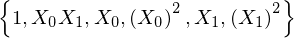

In [9]:
itermonomials([X[0], X[1]], 2)

A not particularly sophisticated function will do the job for me, but it is probably not sufficiently generic:

In [10]:
def get_ncmonomials(variables, degree):
    if not variables:
        return [S.One]
    else:
        _variables = variables[:]
        _variables.insert(0, 1)
        ncmonomials = [S.One]
        for _ in range(degree):
            temp = []
            for var in _variables:
                for new_var in ncmonomials:
                    temp.append(var * new_var)
                    if var != 1 and not var.is_hermitian:
                        temp.append(Dagger(var) * new_var)
            ncmonomials = unique(temp[:])
        return ncmonomials

def unique(seq):
    seen = {}
    result = []
    for item in seq:
        marker = item
        if marker in seen:
            continue
        seen[marker] = 1
        result.append(item)
    return result

It apparently works:

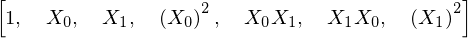

In [11]:
get_ncmonomials(X, 2)

What is astonishing is just how fast it is compared to Yalmip. Matlab finds it hard to handle problems as small as 512 variables with monomials of order 2. The speedup is in the range of 100–400x. The computational complexity of generating monomials does not change, but practical problems are within range.

![Timing results for generating monomials of N noncommutative operators of order 2.](http://peterwittek.com/images/order2.png)
<center>Timing results for generating monomials of N noncommutative operators of order 2.</center>